In [ ]:
# !uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !uv pip install pytorch 
# !uv pip install pytorch_lightning
# !uv pip install torchsummary tensorboardX tensorboard
# !uv pip install kaggle
# !uv pip install matplotlib
# !uv pip install pystac-client planetary-computer
# !uv pip install tifffile
# !uv pip install opencv-python

Audited 3 packages in 2ms


In [4]:
# !kaggle datasets download \
#   -d honeybadger128bit/multispectral-field-images \
#   -p ./data/multispectral-field-images \
#   --unzip


# Sources:
https://github.com/satellite-image-deep-learning/datasets

https://github.com/Agri-Hub/Callisto-Dataset-Collection?tab=readme-ov-file

https://zenodo.org/records/6866847

# Init

In [11]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import geopandas as gpd
import torch
from torch.utils.data import Dataset
import logging
import json
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import tifffile
import cv2
import torch.nn.functional as F

logging.basicConfig(
    level=logging.WARN,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

# honeybadger128bit/multespectral-field-images for scaled testing
https://www.kaggle.com/datasets/honeybadger128bit/multespectral-field-images

## Download

In [6]:
def download_kaggle_dataset(dataset_slug: str, target_dir: str, unzip: bool = True):
    """
    Downloads a Kaggle dataset and (optionally) unzips it.

    :param dataset_slug: The Kaggle dataset identifier, e.g. "honeybadger128bit/multespectral-field-images"
    :param target_dir: Where to download / extract the dataset
    :param unzip: Whether to unzip the downloaded zip file(s)
    """
    api = KaggleApi()
    api.authenticate()

    os.makedirs(target_dir, exist_ok=True)

    logging.info(f"Downloading dataset {dataset_slug} to {target_dir} …")
    api.dataset_download_files(dataset_slug, path=target_dir, unzip=False)

    # Find downloaded zip(s) and optionally unzip
    for fname in os.listdir(target_dir):
        if fname.endswith(".zip"):
            full_path = os.path.join(target_dir, fname)
            logging.info(f"Found zip: {full_path}")
            if unzip:
                logging.info(f"Unzipping {full_path} …")
                with zipfile.ZipFile(full_path, 'r') as z:
                    z.extractall(target_dir)
                logging.info(f"Removing zip file {full_path}")
                os.remove(full_path)

if __name__ == "__main__":
    # Example usage
    dataset = "honeybadger128bit/multespectral-field-images"
    target_directory = "raw_data/multispectral_images"

    # download_kaggle_dataset(dataset, target_directory, unzip=True)

channel_titles = [
            "B01 – Coastal aerosol (442.7 nm)",
            "B02 – Blue (492.4 nm)",
            "B03 – Green (559.8 nm)",
            "B04 – Red (664.6 nm)",
            "B05 – Vegetation Red Edge (704.1 nm)",
            "B06 – Vegetation Red Edge (740.5 nm)",
            "B07 – Vegetation Red Edge (782.8 nm)",
            "B08 – NIR (832.8 nm)",
            "B8A – Narrow NIR (864.7 nm)",
            "B09 – Water Vapour (945.1 nm)",
            "B11 – SWIR (1613.7 nm)",
            "B12 – SWIR (2202.4 nm)",
            "CLD – Cloud Mask"
        ]

# Extract Necessary Data

In [22]:

os.makedirs("data/multispectral_field_images/", exist_ok=True)

logging.info("Loading annotations...")
table1 = pd.read_csv('./raw_data/multispectral_images/table_field1.csv')
table2 = pd.read_csv('./raw_data/multispectral_images/table_field2.csv')
df = pd.concat([table1, table2], ignore_index=True)
logging.info(f"Loaded annotaions:\n\r{df.head(1)}")

logging.info("Transforming images...")
for _, row in df.iterrows():
    json_path = row["path"]

    json_path = json_path.replace("files/", "raw_data/multispectral_images/")
    json_path = json_path + ".json"
    with open(json_path, "r") as f:
        data = json.load(f)

    matrix_3d = np.array(data["data"])

    # Convert BGR to RGB
    bgr_data = matrix_3d[:, :, 1:4]
    rgb_data: np.ndarray = bgr_data[:, :, ::-1]


    multispectral_data = matrix_3d[:, :, [2, 3, 5, 7]]

    full_data = np.concatenate([rgb_data, multispectral_data], axis=2)
    full_data = cv2.normalize(full_data, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

    full_data_path = row["path"].replace("files/images/field", "data/multispectral_field_images/field") + ".tiff"
    
    tifffile.imwrite(full_data_path, full_data)

    # print(full_data.shape)
    # plt.imshow(cv2.normalize(multispectral_data_resized, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U))


    logging.info(f"Transformed & saved image: {json_path}")

(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 198, 7)
(152, 

KeyboardInterrupt: 

## Data Preparing Augmentation

Aplying all transformations to the dataset then cropping images to 96x96 for rgb and 48x48 for multispectral images. Saving to tensors

In [36]:
os.makedirs("dataset/multispectral_field_images/input", exist_ok=True)
os.makedirs("dataset/multispectral_field_images/output", exist_ok=True)
i = 0
for _, row in df.iterrows():

    datapoint_path = row["path"].replace("files/images/field", "data/multispectral_field_images/field")
    datapoint_path = datapoint_path + ".tiff"
    datapoint_tiff = tifffile.imread(datapoint_path)
    tensor_const = torch.tensor(datapoint_tiff, dtype=torch.float32)

    # Apply data augmentation
    for i in range(4):
        data_tensor = tensor_const
        # Random horizontal flip
        if torch.rand(1) < 0.5:
            data_tensor = torch.flip(data_tensor, dims=[-1])

        # Random vertical flip
        if torch.rand(1) < 0.5:
            data_tensor = torch.flip(data_tensor, dims=[-2])

        
        # Random rotation with smooth rotation (using interpolation)
        if torch.rand(1) < 0.9:
            # Generate a random rotation angle between -45 and 45 degrees
            angle = torch.empty(1).uniform_(-45, 45).item()

            device = data_tensor.device
            angle_rad = torch.tensor(angle * torch.pi / 180, device=device)
            cos_a = torch.cos(angle_rad)
            sin_a = torch.sin(angle_rad)

            R = torch.tensor([[cos_a, -sin_a],
                            [sin_a,  cos_a]], dtype=torch.float32)

            # Get spatial dims
            H, W = data_tensor.shape[0], data_tensor.shape[1]

            # Create pixel coordinate grid
            y, x = torch.meshgrid(
                torch.arange(H, dtype=torch.float32),
                torch.arange(W, dtype=torch.float32),
                indexing='ij'
            )

            # Center coordinates
            x_c = x - (W - 1) / 2
            y_c = y - (H - 1) / 2

            # Stack for rotation → shape (2, H*W)
            coords = torch.stack([x_c, y_c], dim=0).reshape(2, -1)

            # Apply inverse rotation
            coords_rot = R @ coords
            coords_rot = coords_rot.reshape(2, H, W)

            # Shift back
            x_rot = coords_rot[0] + (W - 1) / 2
            y_rot = coords_rot[1] + (H - 1) / 2

            # --- Normalize grid to [-1, 1] (VERY IMPORTANT!) ---
            x_norm = 2 * (x_rot / (W - 1)) - 1
            y_norm = 2 * (y_rot / (H - 1)) - 1

            grid = torch.stack([x_norm, y_norm], dim=-1).unsqueeze(0)  # (1, H, W, 2)

            # Apply grid_sample
            data_tensor = F.grid_sample(
                data_tensor.permute(2, 0, 1).unsqueeze(0),  # (1, C, H, W)
                grid,
                mode='bilinear',
                padding_mode='zeros',
                align_corners=False
            ).squeeze(0).permute(1, 2, 0)

        # Random noise addition
        if torch.rand(1) < 0.9:
            noise = torch.randn_like(data_tensor) * 0.01
            data_tensor = data_tensor + noise

        # Random 96x96 crop
        h, w = data_tensor.shape[0], data_tensor.shape[1]
        top = torch.randint(0, h - 96 + 1, (1,)).item()
        left = torch.randint(0, w - 96 + 1, (1,)).item()
        data_tensor = data_tensor[top:top+96, left:left+96]

        output_tensor_path = row["path"].replace("files/images/field", f"dataset/multispectral_field_images/output/rgb{i}_field")+".pt"

        # Save the resulting tensor
        torch.save(data_tensor, output_tensor_path)

        # Process last 4 channels
        input_tensor = data_tensor.clone()
        last_4_channels = input_tensor[..., -4:]  # Extract last 4 channels

        # Resize each of the last 4 channels in half
        resized_half = F.interpolate(
            last_4_channels.permute(2, 0, 1).unsqueeze(0),  # (1, 4, H, W)
            scale_factor=0.5,
            mode='bilinear',
            align_corners=False
        ).squeeze(0).permute(1, 2, 0)

        # Resize back to original size (2x)
        resized_2x = F.interpolate(
            resized_half.permute(2, 0, 1).unsqueeze(0),  # (1, 4, H, W)
            scale_factor=2.0,
            mode='bilinear',
            align_corners=False
        ).squeeze(0).permute(1, 2, 0)

        # Override last 4 channels with the processed version
        input_tensor[..., -4:] = resized_2x

        # Save the modified tensor as input tensor
        output_tensor_path = row["path"].replace("files/images/field", f"dataset/multispectral_field_images/input/rgb{i}_field") + ".pt"
        torch.save(input_tensor, output_tensor_path)

        i+=1

logging.info(f"Storing {i} datapoints")

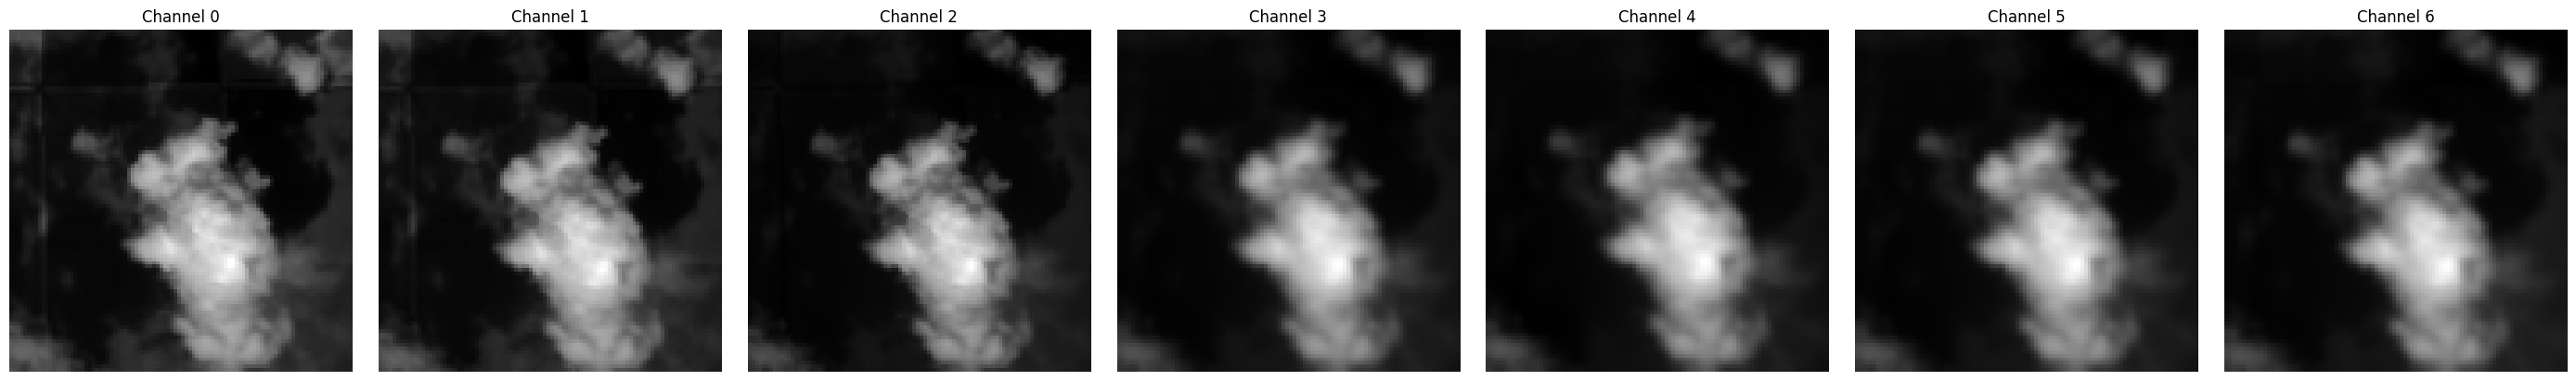

In [35]:
def visualize_tensor(tensor):
    # Convert to numpy for visualization
    tensor_np = tensor.detach().cpu().numpy()

    # Handle different tensor shapes
    if tensor_np.ndim == 3:
    # If tensor has channels first format (C, H, W), transpose to (H, W, C)
        if tensor_np.shape[0] < tensor_np.shape[2]:
            tensor_np = np.transpose(tensor_np, (1, 2, 0))

        # If we have more than 3 channels, visualize each channel separately
        if tensor_np.shape[2] > 3:
            num_channels = tensor_np.shape[2]
            fig, axes = plt.subplots(1, num_channels, figsize=(4*num_channels, 4))
            if num_channels == 1:
                axes = [axes]
            for i in range(num_channels):
                axes[i].imshow(tensor_np[:, :, i], cmap='gray')
                axes[i].set_title(f'Channel {i}')
                axes[i].axis('off')
            plt.tight_layout()
        else:
            # For 3 or fewer channels, visualize as RGB
            plt.figure(figsize=(8, 8))
            if tensor_np.shape[2] == 1:
                plt.imshow(tensor_np.squeeze(), cmap='gray')
            else:
                plt.imshow(tensor_np)
            plt.title('Loaded Tensor Visualization')
            plt.show()
    else:
        # For 2D tensors (H, W)
        plt.figure(figsize=(8, 8))
        plt.imshow(tensor_np, cmap='gray')
        plt.title('Loaded Tensor Visualization')
        plt.show()

def load_and_visualize_tensor(path):
    # Load the .pt file
    tensor = torch.load(path)
    visualize_tensor(tensor)


# Example usage:
load_and_visualize_tensor("dataset/multispectral_field_images/input/rgb0_field1_image5_2017-05-28.pt")

# Full Dataset
https://registry.opendata.aws/sentinel-2-l2a-cogs/ \
https://www.matecdev.com/posts/landsat-sentinel-aws-s3-python.html

In [ ]:
from pystac_client import Client
stac_url = "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
catalog = Client.open(stac_url)
print(catalog)

collections = catalog.get_collections()
for c in collections:
    if "sentinel" in c.id.lower():
        print(c.id, "-", c.title)



<Client id=microsoft-pc>
sentinel-1-rtc - Sentinel 1 Radiometrically Terrain Corrected (RTC)
sentinel-2-l2a - Sentinel-2 Level-2A
sentinel-1-grd - Sentinel 1 Level-1 Ground Range Detected (GRD)
sentinel-5p-l2-netcdf - Sentinel-5P Level-2
sentinel-3-olci-wfr-l2-netcdf - Sentinel-3 Water (Full Resolution)
sentinel-3-synergy-aod-l2-netcdf - Sentinel-3 Global Aerosol
sentinel-3-synergy-v10-l2-netcdf - Sentinel-3 10-Day Surface Reflectance and NDVI (SPOT VEGETATION)
sentinel-3-olci-lfr-l2-netcdf - Sentinel-3 Land (Full Resolution)
sentinel-3-sral-lan-l2-netcdf - Sentinel-3 Land Radar Altimetry
sentinel-3-slstr-lst-l2-netcdf - Sentinel-3 Land Surface Temperature
sentinel-3-slstr-wst-l2-netcdf - Sentinel-3 Sea Surface Temperature
sentinel-3-sral-wat-l2-netcdf - Sentinel-3 Ocean Radar Altimetry
sentinel-3-slstr-frp-l2-netcdf - Sentinel-3 Fire Radiative Power
sentinel-3-synergy-syn-l2-netcdf - Sentinel-3 Land Surface Reflectance and Aerosol
sentinel-3-synergy-vgp-l2-netcdf - Sentinel-3 Top of A